# Clustering of genomic sequences with Mixture Models


The goal of the project is to implement a mixture model that be able to cluster genomic sequences. 
This jupyter notebook will serve as a guide for the different steps of the implementation. 

### For grading, you are just expected to fill in this notebook. However the accompanying project sheet contains complementary information and it is recommended to study it before.

## Representative sequences 

Sequences will be encoded as vectors of integers with values between 0 (A) and 3 (T). 

We will first code functions to estimate a representative from a set of sequences and to compute the probability of a sequence given a representative and an error rate.


In [11]:
import numpy as np
import math
import random
##Constants
nDNA = 4

c1 = np.array([0,1,3,1,3]) #c1 is the sequence ACTAT
c2 = np.array([1,1,1,0,3]) #c2 is the sequence CCCAG
#(s1,s2,s3) = (ACACA, ACTAT, CCTAG)
s = np.array([[0,1,0,1,0], [0,1,3,1,3], [1,1,3,0,2]]) 

print(c1,c2)

print(s)


[0 1 3 1 3] [1 1 1 0 3]
[[0 1 0 1 0]
 [0 1 3 1 3]
 [1 1 3 0 2]]


## Simulating sequences

### Write a functions to simulate a set of sequences from a cluster.

This function will take as input a representative `c` the error rate `mu` and `n` the number of sequences
to generate and return a numpy array of dimension `(n, len(c))`.


In [12]:
def simulate_seqs(n, c, mu):
    """
    int * ndarray[int] * ndarray[float] -> ndarray[int,int]
    """
    seqs = np.tile(c, (n,1))

    #your code here
    for i in range(n):
        for j,nucleotide in enumerate(seqs[i]):
            if np.random.choice([True,False],p=[mu,1-mu]):
                seqs[i][j] = np.random.choice(np.delete(np.arange(nDNA),nucleotide))
    return seqs

##Simulate 100 sequences with mu=0.1 and verify that the average percentage
##of mutation is indeed 10%
sims = simulate_seqs(100,c1,0.1)

# for 100 generated sequences of length n, we have 100*n times the possibility of
# a mutation occurrence. With our sequences of length 5 we have 500 possibilities of 
# a mutation occurrence. With 10% probability, this should be around 50 changes
# from the initial sequence.

# TODO: Hamming distance?

changes = 0
seq_change = 0
for sim in sims:
    if np.array_equal(c1,sim):
        seq_change+=1
    for i,nucleotide in enumerate(sim):
        if nucleotide != c1[i]:
            changes+=1

print(changes)
print(seq_change) ##50-60% of the sequences are changed

58
53


## Computing sequence probabilities

### 1. Write a function that computes the log probability for a set of sequences

It will take as input a matrix of sequences, the representative, and the  error rate `mu`


In [13]:
def LogProbabilities(s, c, mu,compute_log=True):
    """
    ndarray[int,int] *ndarray[int] * float -> ndarray[float]
    """
    nseqs,L = s.shape
    logprobas = np.zeros(nseqs, dtype=float)
    ##
    ## Your code here
    for i in range(nseqs):
        hamming_d = np.count_nonzero(s[i]!=c)
        logprobas[i] = (1-mu)**(L-hamming_d)*(mu/3)**hamming_d
    if compute_log:
        return np.log(logprobas)
    return(logprobas)
    

print (LogProbabilities(s, c1, 0.09))
print("expected result:",np.log([0.91**3*0.03**2, 0.91**5, 0.91**2 * 0.03**3]))
print (LogProbabilities(s, c2, 0.09))

[ -7.29604783  -0.4715534  -10.70829505]
expected result: [ -7.29604783  -0.4715534  -10.70829505]
[-14.12054227 -10.70829505  -7.29604783]


### 2. Compute the class posteriors 

This function takes as argument a set of representatives, a set of error rate and the class priors and returns a 
matrix of all the class posterior. You can use the function `LogProbabilities` to simplify the computation.


In [14]:
def ClassPosterior(s, list_c, list_mu, priors):
    """
    ndarray[int, int] * ndarray[int] * ndarray[float] * ndarray[float] -> ndarray[float, float]
    
    """
    nseqs, L = s.shape
    K = len(list_c)
    ###
    ### Your code here
    class_posteriors = np.zeros((nseqs, K))

    for k in range(K):
        probs = LogProbabilities(s, list_c[k], list_mu[k],compute_log=False) 
        class_posteriors[:, k] = probs * priors[k]
    # Normalize
    class_posteriors /= np.max(class_posteriors, axis=1, keepdims=True)
    class_posteriors /= np.sum(class_posteriors, axis=1, keepdims=True)

    return class_posteriors

mus = np.array([0.09,0.09])
pi = np.array([0.5, 0.5])
               
print(ClassPosterior(s, [c1, c2], mus, pi))
##Expected output
#[[9.98914355e-01 1.08564536e-03]
# [9.99964172e-01 3.58281206e-05]
# [3.19148936e-02 9.68085106e-01]]

[[9.98914355e-01 1.08564536e-03]
 [9.99964172e-01 3.58281206e-05]
 [3.19148936e-02 9.68085106e-01]]


### 3. Compute the loglikelihood of the sequences

Compute the conditional loglikelihood of the sequences by integrating over all possible class membership (note that you will have to compute an exponential of the logprobabilities computed with the previous function.
$$
\log P(s_1,\ldots, s_n \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) = 
\sum_{i=1}^n \log \Big(\sum_{i=1}^K \pi_k P(s_i \mid z_i = k)\Big)
$$
(note: $z_i$ is the class of the sequence $s_i$)

In [15]:
def conditional_loglikelihood(s, list_c, list_mu, priors):
    """
    ndarray[int, int] * ndarray[int] * ndarray[float] * ndarray[float] -> float
    """
    nseqs, L = s.shape
    K = len(list_c)
    ##Your code here
    
    loglikelihood = 0.0
    for i in range(nseqs):
        inner_sum = 0.0
        for k in range(K):
            inner_sum += priors[k] * np.exp(LogProbabilities(s[i:i+1], list_c[k], list_mu[k]))[0]
        loglikelihood += np.log(inner_sum)
    
    return loglikelihood

result = conditional_loglikelihood(s, [c1, c2], mus, pi)
print(result)

-17.109533265532214


## Estimating class representatives and implementing EM _light_

In the following we will implement a simplified version of EM with binary class allocations (each sequence is in the class where it has the highest posterior probability).

We will first write a function to update class representative and error rate from a set of sequences and then
implement EM


### 1. Write two functions, one to estimate the sequence representative and one to estimate the error rate

From set of sequences, we compute first the profile of the sequences at each position and as consensus the most
represented nucleotide. We then estimate the error rate by counting the number of differences to the consensus.



In [16]:
def estimate_representative(s):
    """
    ndarray[int, int] -> ndarray[int]
    from a n * L matrix of sequences, returns the consensus sequence 

    """

    nseqs,L = s.shape
    profile = np.zeros(L)
    for i in range(L):
        profile[i] = np.argmax(np.bincount(s[:,i], minlength=4))
    return profile
    
def estimate_error_rate(s, c):
    """
    ndarray[int, int] -> float
    """
    nseqs, L = s.shape
    nerrors = np.count_nonzero(s!=c)
    return nerrors/(L*nseqs)

c = estimate_representative(s)
mu = estimate_error_rate(s,c)
print(c) # [0 1 3 1 0]
print(mu) # 0.3333333333333333
    

[0. 1. 3. 1. 0.]
0.3333333333333333


### 2. Implementing EM

We will implement the EM algorithm with fixed class allocation:

0. fix the number of clusters $K$
1. Initialise random allocation of the representative
2. Until convergence
    - Compute the class posteriors for each sequence
    - Allocate each sequence to the most probable class
    - Update cluster representative and error rate

Note that this algorithm works in the spirit of the K-means algorithm in the sense that the class allocations are fixed at each step. However, an adapation of K-means to multinoulli would only estimate class centers. Here we estimate class centers $c_k$ and the error rate $\mu_k$ for each class.

For the convergence criterion we can monitor the class representatives and stop when they do not change anymore.

The function will return a matrix (K x L) of the class representatives, a vector of the class proportions and optionally a vector of the likelihoods at each iteration.



In [17]:
def EM(s,K, priors=None, return_likelihood = False, return_assignment = False):
    """
    ndarray[int,int] * int -> (ndarray[int, int], ndarray[float], ndarray[float])
    """   
    break_point=100
    nseqs, L = s.shape
    representative = np.random.choice(nDNA,size=(K,L)) #initilization of random representative
    error_rate = np.full((K), 0.09) #initialize error rate
    if priors==None:
        priors = np.full((K), 1/K) #initialize priors
    cnt = 0
    
    #do until convergence:
    likelihoods = []
    while(True):
        prev_rep = np.copy(representative)
        posteriors = ClassPosterior(s, representative, error_rate, priors)
        cluster_assignment = np.argmax(posteriors, axis=1)
        for k in range(K):
            cur_seq = s[cluster_assignment == k]
            if len(cur_seq)!=0: 
                new_rep = estimate_representative(cur_seq)
                new_error_rate = estimate_error_rate(cur_seq, new_rep)
                
                representative[k] = new_rep
                error_rate[k] = new_error_rate
                priors[k] = len(cur_seq)/nseqs
        cnt+=1
        likelihood = conditional_loglikelihood(s,representative,error_rate,priors)
        likelihoods.append(likelihood)
        if cnt>=break_point:
            break
        if np.array_equal(prev_rep, representative):
            break
    if return_likelihood and return_assignment:
        return representative, priors, likelihoods, cluster_assignment
    elif return_likelihood:
        return representative, priors, likelihoods
    elif return_assignment:
        return representative, priors, cluster_assignment
    else:
        return representative, priors
new_sims = np.concatenate((simulate_seqs(100,c1,0.1),simulate_seqs(100,c2,0.1)))
EM(new_sims,2)
#schaut ganz gut aus.. sind die c1,c2 reps

(array([[1, 1, 1, 0, 3],
        [0, 1, 3, 1, 3]]),
 array([0.5, 0.5]))

### 3. Validating on simulated data


The file `simul_3_clusters.csv` contains a simulation of 400 sequences of length 100 sampled from 3 clusters with proportions $\pi = (0.6, 0.3, 0.1) $. 
- Apply EM on the simulated sequences 
- Verify that the estimation of the clusters worked correctly by checking the estimated class representative and the prior (file `simul_representatives.csv`)
- Verify the class allocations as well (file `simul_sequences_class.csv`)
- What are the error rates $(\mu_1, \mu_2, \mu_3)$ for each of the classes?


In [18]:
from numpy import genfromtxt
simul = genfromtxt('simul_3_clusters.csv', delimiter=',').astype(int)
true_rep = genfromtxt('simul_representatives.csv', delimiter=',').astype(int)
true_assignment = genfromtxt('simul_sequences_class.csv', delimiter=',').astype(int)
pi = [0.6,0.3,0.1]

In [19]:
rep,prior,cluster_assignment = EM(simul,3,return_likelihood=False, priors=pi, return_assignment=True)
print("check percentage of same genes between real and estimated cluster: ", np.sum(true_rep==rep)/(rep.shape[0]*rep.shape[1]))
print("check cluster allocation percentage: ", np.sum(true_assignment==cluster_assignment)/true_assignment.shape[0])

# Find accuracy for each possible result
for value in np.unique(true_assignment):
    incorrect_predictions = np.sum((cluster_assignment != value) & (true_assignment == value))
    total_occurrences = np.sum(true_assignment == value)
    
    error_rate = incorrect_predictions / total_occurrences if total_occurrences > 0 else 0
    print(f'Error Rate for value {value}: {error_rate * 100:.2f}%')


check percentage of same genes between real and estimated cluster:  0.6966666666666667
check cluster allocation percentage:  0.6175
Error Rate for value 0: 0.00%
Error Rate for value 1: 100.00%
Error Rate for value 2: 100.00%


### 4. Determining the number of clusters

Run EM for $K$ ranging from 2 to 10 and record the loglikelihood for each adjusted model adjusted.
Plot the value of the loglikelihood against $K$, what do you observe?

/var/folders/wb/xg0x049901g1bkm_c1pvb2700000gp/T/ipykernel_22495/1273564099.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(logprobas)


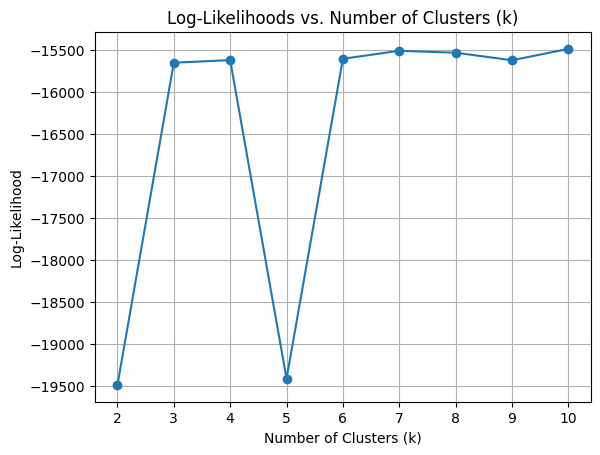

In [25]:
## Write the code here to check the number of clusters.
import matplotlib.pyplot as plt

k_range = range(2,11)
log_likelihoods = []
for k in k_range:
    rep,prior,likelihood = EM(simul,k,return_likelihood=True, return_assignment=False)
    log_likelihoods.append(likelihood[-1])

plt.plot(k_range, log_likelihoods, marker='o')
plt.title('Log-Likelihoods vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()


## Application to real data: Ebola

We gonna apply our clustering method to real sequences from the Ebola epidemics in west Africa in 2014-2016. 
We will first start with a simple "detective work" on a set of simple sequences to understand the questions related to outbreak analysis.  

### 1. Detective training

This part is condensed from an activity proposed on the excellent [HHMI biointeractive website](https://www.biointeractive.org/classroom-resources/ebola-disease-detectives). It is recommended start by reading this [short summary on the Ebola epidemics](https://www.biointeractive.org/sites/default/files/Introduction-to-Ebola.pdf). 

Below is a set of DNA sequences that includes the reference sample from Guinea and 15 Ebola DNA sequences from samples of patients in Sierra Leone. We will reason on those sequences to understand better how genomic information can help understanding the spread of a virus. 


- The shaded nucleotides in sequences 1–15 represent mutations that occurred in these different viruses compared to the reference sequence. (Remember that the reference sequence is from a virus that was present at the start of the outbreak.) 
- Move the Ebola sequences 1–15 around to identify patterns in the mutations.
- Group sequences according to any patterns you see.
- Every sequence should be in a group, even if they are not identical. Use your groupings to answer the analysis questions.

<div>
<img src="ebola_sequences.png" width="400"/>
</div>



#### 1.a Write your groups below



#### 1.b What was your criteria to construct this grouping? Could you have used an alternative criteria?

#### 1.c If a sequence has a larger number of mutations when compared to the reference sequence, does that mean it is from earlier or later in the outbreak? Explain your answer. 

#### 1.d Create a visual that highlights the relationship between your groups. Examples of effective visuals include flowcharts and trees. Be sure that your visual includes an arrow indicating passage of time during the outbreak. 


### 2. Testing the clustering algorithm

Let's apply our clustering algorithm to a set of sequences from the 2014-2016 epidemics. We started from the genome data available on [this website](https://github.com/ebov/space-time) listing 1610 sequences during the pandemics. We selected a subset of sequences and recorded only positions that are changing. We also prepared the data as a numpy array. 

#### 2.a Run the mixture model for different values of $k$ 

#### 2.b Determine the most suited value for $k$. What about the resulting groups, are they very diverse?

In [ ]:
# Loading data

sequences = pkl.load( open('ebola.pkl', 'rb'))

# Running EM with different values for k


# Determine the best value for k

#### 2.c Do you see limitations in applying the clustering algorithm to an outbreak? What are the advantages? What would be an alternative method?